In [21]:
# !pip install yahoo_fin
# !pip install yoptions
# !pip install pandas_datareader
# pip install lightgbm
# !pip install --upgrade xlrd

In [22]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
import os
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import data
from functools import reduce
import yoptions as yo
from yahoo_fin import options
from scipy.stats import norm
from tabulate import tabulate

# 1. Data

### Связывание N разных файлов в 1 файл (Предварительно скачанных с сайта Investing.com (библиотека в момент написания работы не работала из-за обновления firewall), либо с сайта CFTC)

In [23]:
# os.chdir("C:/Users/pshein/Desktop/Другое/Учёба/Выгрузки/CFTC FUTURES ONLY")
# extension = 'xls'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# #combine all files in the list
# combined_csv = pd.concat([pd.read_excel(f) for f in all_filenames])
# #export to csv
# combined_csv.to_csv( "futures_statistics.csv", index=False, encoding='utf-8-sig')

### Функция берет csv файлы с котировками commodities и в каждый из них добавляет отдельным столбцом наименование самого commodity + в самой папке называет именем базисного актива

In [24]:
# def adding_commodity_name(direction):
    
#     path_multiplied = os.path.join(fr'{direction}/*.csv')
    
#     for i in glob.glob(path_multiplied):
#         df = pd.read_csv(i)
#         name = str(i.rpartition('Investing.com')[-1][1:-4].replace(" ",'_').replace('_Historical_Data', ''))
#         df['ticker'] = name
#         df.to_csv(fr'C:/Users/pshein/Desktop/Другое/Учёба/Выгрузки/Investing.com/name_added/{name}.csv')
        
# adding_commodity_name('C:/Users/LT17/Desktop/Другое/Учёба/ВКР/От 23.12.22/Выгрузки/Выгрузки/Investing.com/Investing.com')

### Соединяем обновленные csv воедино

In [25]:
# os.chdir("C:/Users/LT17/Desktop/Другое/Учёба/ВКР/От 23.12.22/Выгрузки/Выгрузки/Investing.com/name_added")
# extension = 'csv'

# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# #combine all files in the list
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
# #
# #export to csv
# combined_csv.to_csv( "all_commodities_modified.csv", index=False, encoding='utf-8-sig')
# #
# #Проводим настройку итогового датафрейма
# combined_csv = combined_csv.applymap(lambda x: str(x).replace(',', ''))
# combined_csv.drop(columns = ['Unnamed: 0'], inplace = True)
# combined_csv.Date = pd.to_datetime(combined_csv.Date)
# #
# combined_csv.Price = combined_csv.Price.astype('float')
# combined_csv.Open = combined_csv.Open.astype('float')
# combined_csv.High = combined_csv.High.astype('float')
# combined_csv.Low = combined_csv.Low.astype('float')
# #
# combined_csv.rename(columns = {'Vol.': 'Volume',
#                                'Change %': 'growth_rate'}, inplace = True)
# combined_csv.Volume.replace('nan', 0, inplace = True)
# combined_csv.growth_rate = combined_csv.growth_rate.apply(lambda x: str(x).replace('%', ''))
# combined_csv.ticker = combined_csv.ticker.apply(lambda x: str(x).replace('HistoricalData', '')) ####
# #
# combined_csv.Date = pd.to_datetime(combined_csv.Date) ####
# combined_csv['year'] = combined_csv.Date.dt.year

### Вариант, когда уже есть датафрейм, получившийся с предыдущего шага

In [26]:
combined_csv = pd.read_csv('D:/Учёба/ВКР/ВсеВыгрузки/all_commodities_modified.csv')
combined_csv = combined_csv.applymap(lambda x: str(x).replace(',', ''))
combined_csv.drop(columns = ['Unnamed: 0'], inplace = True)
combined_csv.Date = pd.to_datetime(combined_csv.Date)
#
combined_csv.Price = combined_csv.Price.astype('float')
combined_csv.Open = combined_csv.Open.astype('float')
combined_csv.High = combined_csv.High.astype('float')
combined_csv.Low = combined_csv.Low.astype('float')
#
combined_csv.rename(columns = {'Vol.': 'Volume',
                               'Change %': 'growth_rate'}, inplace = True)
combined_csv.Volume.replace('nan', 0, inplace = True)
combined_csv.growth_rate = combined_csv.growth_rate.apply(lambda x: str(x).replace('%', ''))
combined_csv.ticker = combined_csv.ticker.apply(lambda x: str(x).replace('HistoricalData', '')) ####
#
combined_csv.Date = pd.to_datetime(combined_csv.Date) ####
combined_csv['year'] = combined_csv.Date.dt.year

### Убираем K & M из столбца Volume

In [27]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

combined_csv.growth_rate = combined_csv.growth_rate.apply(lambda x: float(x))
combined_csv.Volume = combined_csv.Volume.apply(value_to_float)

In [28]:
cftc = pd.read_csv('D:/Учёба/ВКР/ВсеВыгрузки/CFTC_futures_only.csv')

cftc.applymap(lambda x: str(x).replace(',', '.'))
cftc.Open_Interest_All = cftc.Open_Interest_All.apply(lambda x: str(x).replace(',', ''))
cftc.Report_Date_as_MM_DD_YYYY = pd.to_datetime(cftc.Report_Date_as_MM_DD_YYYY)

cftc['difference'] = cftc.Tot_Rept_Positions_Long_All - cftc.Tot_Rept_Positions_Short_All

cftc.Open_Interest_All = cftc.Open_Interest_All.astype('int')
cftc = cftc.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True)
cftc['year'] = cftc.Report_Date_as_MM_DD_YYYY.dt.year

cftc.head(3)

,Market_and_Exchange_Names,As_of_Date_In_Form_YYMMDD,Report_Date_as_MM_DD_YYYY,CFTC_Contract_Market_Code,CFTC_Market_Code,CFTC_Region_Code,CFTC_Commodity_Code,Open_Interest_All,Prod_Merc_Positions_Long_ALL,Prod_Merc_Positions_Short_ALL,Swap_Positions_Long_All,Swap__Positions_Short_All,Swap__Positions_Spread_All,M_Money_Positions_Long_ALL,M_Money_Positions_Short_ALL,M_Money_Positions_Spread_ALL,Other_Rept_Positions_Long_ALL,Other_Rept_Positions_Short_ALL,Other_Rept_Positions_Spread_ALL,Tot_Rept_Positions_Long_All,Tot_Rept_Positions_Short_All,NonRept_Positions_Long_All,NonRept_Positions_Short_All,Open_Interest_Old,Prod_Merc_Positions_Long_Old,Prod_Merc_Positions_Short_Old,Swap_Positions_Long_Old,Swap_Positions_Short_Old,Swap_Positions_Spread_Old,M_Money_Positions_Long_Old,M_Money_Positions_Short_Old,M_Money_Positions_Spread_Old,Other_Rept_Positions_Long_Old,Other_Rept_Positions_Short_Old,Other_Rept_Positions_Spread_Old,Tot_Rept_Positions_Long_Old,Tot_Rept_Positions_Short_Old,NonRept_Positions_Long_Old,NonRept_Positions_Short_Old,Open_Interest_Other,Prod_Merc_Positions_Long_Other,Prod_Merc_Positions_Short_Other,Swap_Positions_Long_Other,Swap_Positions_Short_Other,Swap_Positions_Spread_Other,M_Money_Positions_Long_Other,M_Money_Positions_Short_Other,M_Money_Positions_Spread_Other,Other_Rept_Positions_Long_Other,Other_Rept_Positions_Short_Other,Other_Rept_Positions_Spread_Othr,Tot_Rept_Positions_Long_Other,Tot_Rept_Positions_Short_Other,NonRept_Positions_Long_Other,NonRept_Positions_Short_Other,Change_in_Open_Interest_All,Change_in_Prod_Merc_Long_All,Change_in_Prod_Merc_Short_All,Change_in_Swap_Long_All,Change_in_Swap_Short_All,Change_in_Swap_Spread_All,Change_in_M_Money_Long_All,Change_in_M_Money_Short_All,Change_in_M_Money_Spread_All,Change_in_Other_Rept_Long_All,Change_in_Other_Rept_Short_All,Change_in_Other_Rept_Spread_All,Change_in_Tot_Rept_Long_All,Change_in_Tot_Rept_Short_All,Change_in_NonRept_Long_All,Change_in_NonRept_Short_All,Pct_of_Open_Interest_All,Pct_of_OI_Prod_Merc_Long_All,Pct_of_OI_Prod_Merc_Short_All,Pct_of_OI_Swap_Long_All,Pct_of_OI_Swap_Short_All,Pct_of_OI_Swap_Spread_All,Pct_of_OI_M_Money_Long_All,Pct_of_OI_M_Money_Short_All,Pct_of_OI_M_Money_Spread_All,Pct_of_OI_Other_Rept_Long_All,Pct_of_OI_Other_Rept_Short_All,Pct_of_OI_Other_Rept_Spread_All,Pct_of_OI_Tot_Rept_Long_All,Pct_of_OI_Tot_Rept_Short_All,Pct_of_OI_NonRept_Long_All,Pct_of_OI_NonRept_Short_All,Pct_of_Open_Interest_Old,Pct_of_OI_Prod_Merc_Long_Old,Pct_of_OI_Prod_Merc_Short_Old,Pct_of_OI_Swap_Long_Old,Pct_of_OI_Swap_Short_Old,Pct_of_OI_Swap_Spread_Old,Pct_of_OI_M_Money_Long_Old,Pct_of_OI_M_Money_Short_Old,Pct_of_OI_M_Money_Spread_Old,Pct_of_OI_Other_Rept_Long_Old,Pct_of_OI_Other_Rept_Short_Old,Pct_of_OI_Other_Rept_Spread_Old,Pct_of_OI_Tot_Rept_Long_Old,Pct_of_OI_Tot_Rept_Short_Old,Pct_of_OI_NonRept_Long_Old,Pct_of_OI_NonRept_Short_Old,Pct_of_Open_Interest_Other,Pct_of_OI_Prod_Merc_Long_Other,Pct_of_OI_Prod_Merc_Short_Other,Pct_of_OI_Swap_Long_Other,Pct_of_OI_Swap_Short_Other,Pct_of_OI_Swap_Spread_Other,Pct_of_OI_M_Money_Long_Other,Pct_of_OI_M_Money_Short_Other,Pct_of_OI_M_Money_Spread_Other,Pct_of_OI_Other_Rept_Long_Other,Pct_of_OI_Other_Rept_Short_Other,Pct_of_OI_Other_Rept_Spread_Othr,Pct_of_OI_Tot_Rept_Long_Other,Pct_of_OI_Tot_Rept_Short_Other,Pct_of_OI_NonRept_Long_Other,Pct_of_OI_NonRept_Short_Other,Traders_Tot_All,Traders_Prod_Merc_Long_All,Traders_Prod_Merc_Short_All,Traders_Swap_Long_All,Traders_Swap_Short_All,Traders_Swap_Spread_All,Traders_M_Money_Long_All,Traders_M_Money_Short_All,Traders_M_Money_Spread_All,Traders_Other_Rept_Long_All,Traders_Other_Rept_Short_All,Traders_Other_Rept_Spread_All,Traders_Tot_Rept_Long_All,Traders_Tot_Rept_Short_All,Traders_Tot_Old,Traders_Prod_Merc_Long_Old,Traders_Prod_Merc_Short_Old,Traders_Swap_Long_Old,Traders_Swap_Short_Old,Traders_Swap_Spread_Old,Traders_M_Money_Long_Old,Traders_M_Money_Short_Old,Traders_M_Money_Spread_Old,Traders_Other_Rept_Long_Old,Traders_Other_Rept_Short_Old,Traders_Other_Rept_Spread_

### (НА ПРИМЕРЕ ФЬЮЧЕРСА НА ПАЛЛАДИЙ) Расчёт индикатора Ларри Уильямса + динамика цен на базисный актив

In [29]:
palladium = combined_csv.loc[combined_csv.ticker.str.contains('Palladium')].query('year >= 2016')

cftc['rolling_52_min'] = cftc.difference.rolling(52).min()
cftc['rolling_52_max'] = cftc.difference.rolling(52).max()
cftc['Williams_coef'] = round((cftc.difference - cftc['rolling_52_min']) / (cftc['rolling_52_max'] - cftc['rolling_52_min'])*100,2)

n_steps = 7
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

# # Раcчет индикатора Стивена Бриза (Movement Index) (Индекс Ульямса за текущую неделю за вычетом Индекса Ульямса N недель назад)
# # Если Movement Index > 40%, это означает завершение коррекции долгосрочного тренда; 
# # Если Movement Index < -40%, это означает завершение долгосрочного тренда;
cftc['Breeze_coef'] = cftc['Williams_coef'].rolling(window=n_steps).apply(my_fun)

cftc_palladium = cftc.query('Market_and_Exchange_Names == "PALLADIUM - NEW YORK MERCANTILE EXCHANGE"').query('year >= 2016')

In [30]:
palladium = pd.merge(palladium, cftc_palladium[['Williams_coef', 'Report_Date_as_MM_DD_YYYY', 'Breeze_coef']],
                     how = 'left',
                     left_on = 'Date',
                     right_on = 'Report_Date_as_MM_DD_YYYY')
palladium.fillna(method="ffill", inplace = True)
palladium.dropna(inplace = True)

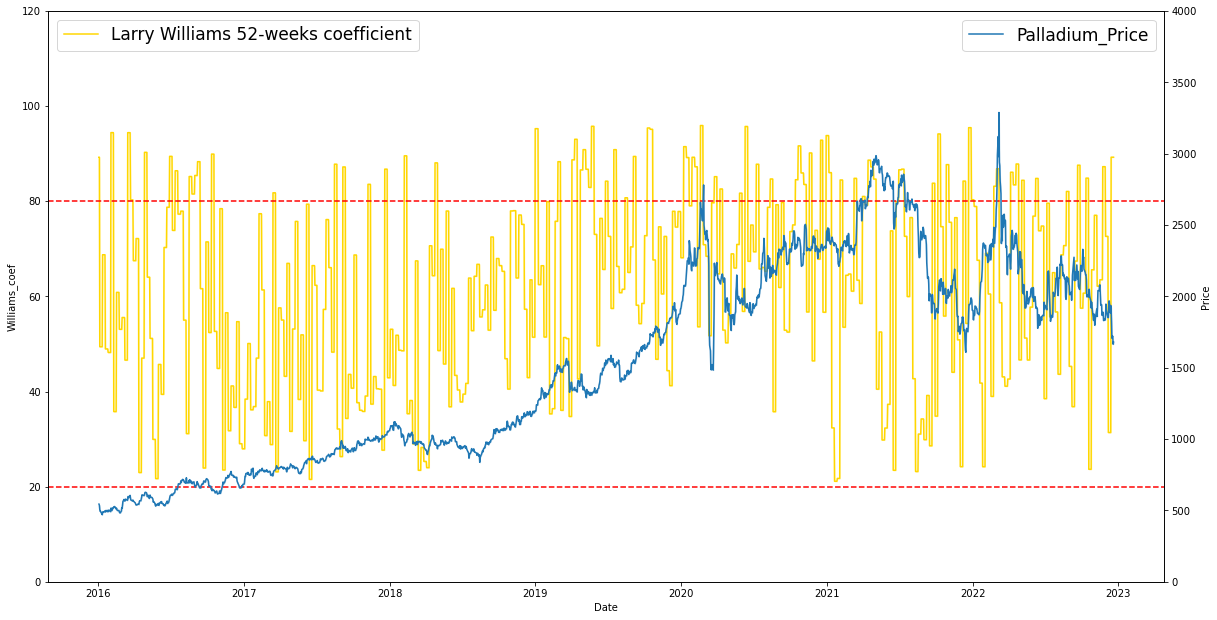

In [31]:
fig,ax = plt.subplots()

sns.lineplot(data = palladium,
             y = palladium.Williams_coef,
             x = palladium.Date,
             color = 'gold',
             label = 'Larry Williams 52-weeks coefficient')

plt.legend(loc='upper left', fontsize = 17)

plt.axhline(y = 20, color = 'r', linestyle = '--')
plt.axhline(y = 80, color = 'r', linestyle = '--')

ax.set_ylim(0, 120)

ax2=ax.twinx() #вторая ось

sns.lineplot(data = palladium,
             y = palladium.Price,
             x = palladium.Date,
             label = 'Palladium_Price')

ax2.set_ylim(0, 4000)
plt.legend(loc='upper right', fontsize = 17)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10.5)

### Расчёт и визуализация индекса Бриза

In [34]:
palladium

,Date,Price,Open,High,Low,Volume,growth_rate,ticker,year,Williams_coef,Report_Date_as_MM_DD_YYYY,Breeze_coef
6,2022-12-13,1936.70,1883.00,2003.00,1880.50,2270.0,2.79,Palladium_Futures,2022,31.39,2022-12-13,9.16
7,2022-12-12,1884.10,1954.00,1959.50,1876.00,1790.0,-4.30,Palladium_Futures,2022,31.39,2022-12-13,9.16
8,2022-12-09,1968.80,1930.50,1972.50,1913.50,1550.0,1.97,Palladium_Futures,2022,31.39,2022-12-13,9.16
9,2022-12-08,1930.80,1854.00,1945.00,1842.00,2040.0,4.13,Palladium_Futures,2022,31.39,2022-12-13,9.16
10,2022-12-07,1854.30,1852.00,1882.50,1839.00,1370.0,0.15,Palladium_Futures,2022,31.39,2022-12-13,9.16
...,...,...,...,...,...,...,...,...,...,...,...,...
26684,2016-01-08,494.20,500.60,500.60,490.95,100.0,0.14,Palladium_Futures,2016,49.42,2016-01-12,1.19
26685,2016-01-07,493.50,506.00,507.30,487.85,170.0,-2.39,Palladium_Futures,2016,49.42,2016-01-12,1.19
26686,2016-01-06,505.60,531.00,531.00,505.90,150.0,-5.71,Palladium_Futures,2016,49.42,2016-01-12,1.19
26687,2016-01-05,536.20,543.40,547.60,536.50,40.0,-1.53,Palladium_Futures,2016,89.27,2016-01-05,-0.08


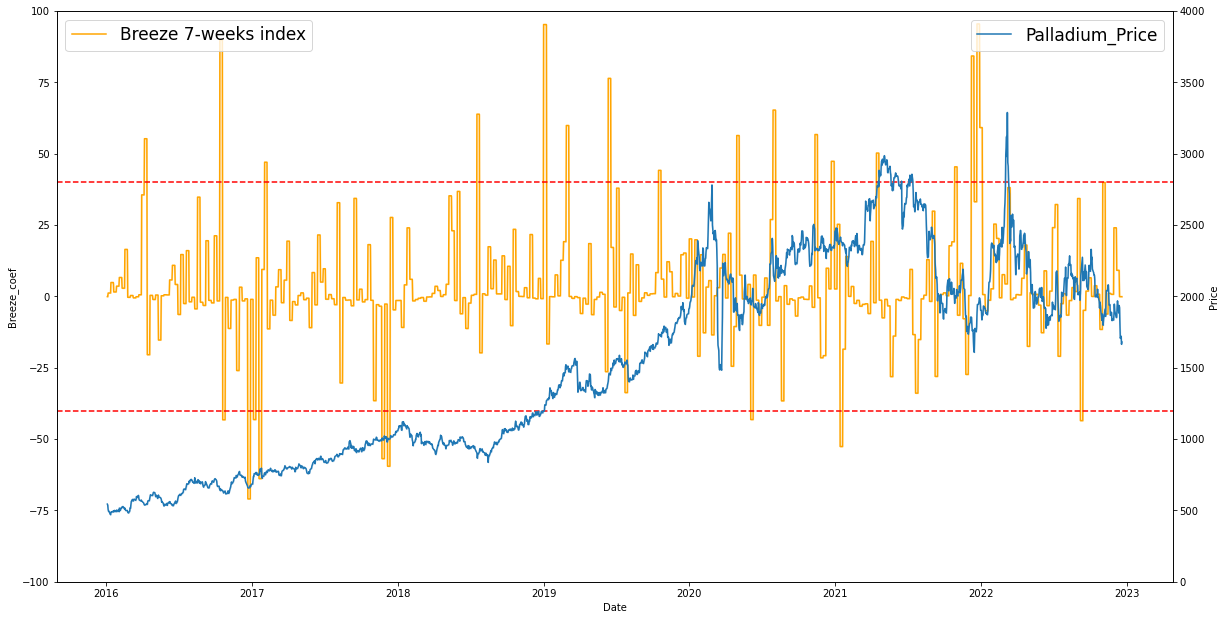

In [37]:
fig,ax = plt.subplots()

sns.lineplot(data = palladium,
             y = palladium.Breeze_coef,
             x = palladium.Date,
             color = 'orange',
             label = 'Breeze 7-weeks index')

plt.legend(loc='upper left', fontsize = 17)

plt.axhline(y = -40, color = 'r', linestyle = '--')
plt.axhline(y = 40, color = 'r', linestyle = '--')

ax.set_ylim(-100, 100)

ax2=ax.twinx()

sns.lineplot(data = palladium,
             y = palladium.Price,
             x = palladium.Date,
             label = 'Palladium_Price')

ax2.set_ylim(0, 4000)

plt.legend(loc='upper right', fontsize = 17)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10.5)